# Census income classification with LightGBM

This notebook demonstrates how to use LightGBM to predict the probability of an individual making over $50K a year in annual income. It uses the standard UCI Adult income dataset.

Gradient boosting machine methods such as LightGBM are state-of-the-art for these types of prediction problems with tabular style input data of many modalities. Tree SHAP allows for the exact computation of SHAP values for tree ensemble methods, and has been integrated directly into the C++ LightGBM code base. This allows fast exact computation of SHAP values without sampling and without providing a background dataset (since the background is inferred from the coverage of the trees).

Here we demonstrate how to use SHAP values to understand LightGBM model predictions.

In [1]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import shap
import os
import pandas as pd

# print the JS visualization code to the notebook
shap.initjs()

In [2]:
A,b = shap.datasets.adult()
# X_display,y_display = shap.datasets.adult(display=True)
A

# create a train/test split
A_train, A_test, b_train, b_test = train_test_split(A, b, test_size=0.2, random_state=7)
da_train = lgb.Dataset(A_train, label=b_train)
da_test = lgb.Dataset(A_test, label=b_test)

In [3]:
len(A['Country'].unique())

42

In [4]:
A.dtypes

Age               float32
Workclass            int8
Education-Num     float32
Marital Status       int8
Occupation           int8
Relationship        int32
Race                 int8
Sex                  int8
Capital Gain      float32
Capital Loss      float32
Hours per week    float32
Country              int8
dtype: object

# Load dataset

In [5]:
pwd = os.getcwd()

In [6]:
dataset = pd.read_csv(pwd+'/adult.csv')

# Basic Data Check

In [7]:
dataset.dtypes

age                 int64
workclass          object
fnlwgt              int64
education          object
educational-num     int64
marital-status     object
occupation         object
relationship       object
race               object
gender             object
capital-gain        int64
capital-loss        int64
hours-per-week      int64
native-country     object
income             object
dtype: object

In [8]:
# Missing Values

dataset.isnull().any()

age                False
workclass          False
fnlwgt             False
education          False
educational-num    False
marital-status     False
occupation         False
relationship       False
race               False
gender             False
capital-gain       False
capital-loss       False
hours-per-week     False
native-country     False
income             False
dtype: bool

In [9]:
# Duplicates
dataset.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
48837    False
48838    False
48839    False
48840    False
48841    False
Length: 48842, dtype: bool

# Features

In [10]:
numerical_features = [num_col for num_col in dataset.select_dtypes('int64')]

In [11]:
numerical_features

['age',
 'fnlwgt',
 'educational-num',
 'capital-gain',
 'capital-loss',
 'hours-per-week']

In [12]:
categorical_features = [cat_col for cat_col in dataset.select_dtypes('object')]

In [13]:
dataset[categorical_features].head()

,workclass,education,marital-status,occupation,relationship,race,gender,native-country,income
0,Private,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,United-States,<=50K
1,Private,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,United-States,<=50K
2,Local-gov,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,United-States,>50K
3,Private,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,United-States,>50K
4,?,Some-college,Never-married,?,Own-child,White,Female,United-States,<=50K


<AxesSubplot:>

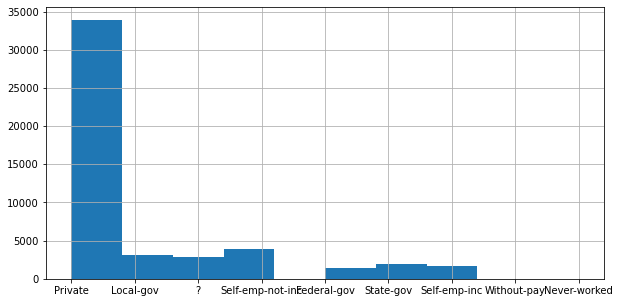

In [14]:
dataset['workclass'].unique()
dataset['workclass'].hist(figsize=(10,5))

In [15]:
len(dataset['native-country'].unique())

42

# Label Encoding for categorical variables

In [16]:
df = dataset.copy()

In [17]:
X_display = df.drop(columns='income')
y_display = df['income']

In [18]:
for col_name in categorical_features:
    dataset[col_name], _ = dataset[col_name].factorize()

In [19]:
dataset[categorical_features].head()

,workclass,education,marital-status,occupation,relationship,race,gender,native-country,income
0,0,0,0,0,0,0,0,0,0
1,0,1,1,1,1,1,0,0,0
2,1,2,1,2,1,1,0,0,1
3,0,3,1,0,1,0,0,0,1
4,2,3,0,3,0,1,1,0,0


In [20]:
dataset['workclass'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64)

In [21]:
dataset.dtypes

age                int64
workclass          int64
fnlwgt             int64
education          int64
educational-num    int64
marital-status     int64
occupation         int64
relationship       int64
race               int64
gender             int64
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country     int64
income             int64
dtype: object

# Model Training 

In [22]:
X = dataset.drop(columns='income')

In [23]:
y = dataset['income']

In [24]:
#create a train/test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)

In [25]:
params = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 10,
    "verbose": -1,
    "min_data": 100,
    "boost_from_average": True
}



In [26]:
model_train = lgb.train(params, d_train,num_boost_round= 10000, valid_sets=[d_test], early_stopping_rounds=50, verbose_eval=1000)
model_a = lgb.train(params, da_train,num_boost_round= 10000, valid_sets=[da_test], early_stopping_rounds=50, verbose_eval=1000)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[771]	valid_0's binary_logloss: 0.276505
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[644]	valid_0's binary_logloss: 0.278029


# Explain Predictions

In [27]:
explainer = shap.TreeExplainer(model_train)
shap_values = explainer.shap_values(X)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [28]:
shap_values[0]

array([[ 0.64694911,  0.05586549, -0.03194437, ...,  0.03940383,
         0.0425581 , -0.00912526],
       [-0.53072148, -0.00222557,  0.15505392, ...,  0.06032799,
        -0.56583757, -0.00366829],
       [ 0.16336276, -0.35311329, -0.18291721, ...,  0.07695552,
        -0.09535478, -0.01977473],
       ...,
       [-0.87008633, -0.01095454,  0.10805287, ...,  0.04265891,
         0.02721902, -0.02041367],
       [ 1.39002379,  0.00346914,  0.01296793, ...,  0.03711311,
         1.16872982, -0.01201502],
       [-0.79009829, -0.18852   , -0.14900824, ...,  0.01978446,
        -0.04851722, -0.01873563]])

In [29]:
shap_values[1]

array([[-0.64694911, -0.05586549,  0.03194437, ..., -0.03940383,
        -0.0425581 ,  0.00912526],
       [ 0.53072148,  0.00222557, -0.15505392, ..., -0.06032799,
         0.56583757,  0.00366829],
       [-0.16336276,  0.35311329,  0.18291721, ..., -0.07695552,
         0.09535478,  0.01977473],
       ...,
       [ 0.87008633,  0.01095454, -0.10805287, ..., -0.04265891,
        -0.02721902,  0.02041367],
       [-1.39002379, -0.00346914, -0.01296793, ..., -0.03711311,
        -1.16872982,  0.01201502],
       [ 0.79009829,  0.18852   ,  0.14900824, ..., -0.01978446,
         0.04851722,  0.01873563]])

## Visualize a single prediction

In [30]:
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_display.iloc[0,:])

## Visualize Several Predictions

In [31]:
shap.force_plot(explainer.expected_value[1], shap_values[1][:1000,:], X_display.iloc[:1000,:])

## SHAP Summary Plot

Rather than use a typical feature importance bar chart, we use a density scatter plot of SHAP values for each feature to identify how much impact each feature has on the model output for individuals in the validation dataset. Features are sorted by the sum of the SHAP value magnitudes across all samples. It is interesting to note that the relationship feature has more total model impact than the captial gain feature, but for those samples where capital gain matters it has more impact than age. In other words, capital gain effects a few predictions by a large amount, while age effects all predictions by a smaller amount.

Note that when the scatter points don't fit on a line they pile up to show density, and the color of each point represents the feature value of that individual.

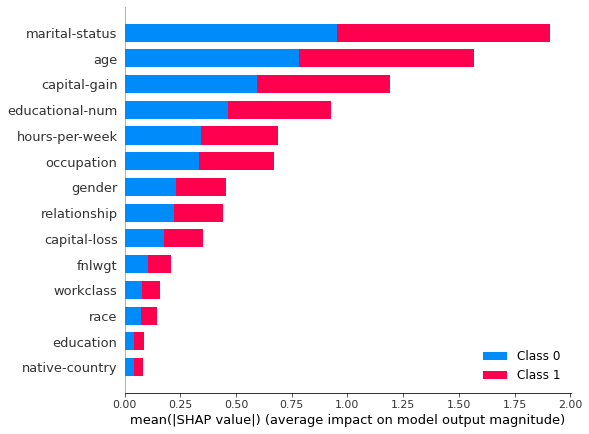

In [32]:
shap.summary_plot(shap_values, X)

## SHAP Dependence Plots

SHAP dependence plots show the effect of a single feature across the whole dataset. They plot a feature's value vs. the SHAP value of that feature across many samples. SHAP dependence plots are similar to partial dependence plots, but account for the interaction effects present in the features, and are only defined in regions of the input space supported by data. The vertical dispersion of SHAP values at a single feature value is driven by interaction effects, and another feature is chosen for coloring to highlight possible interactions.

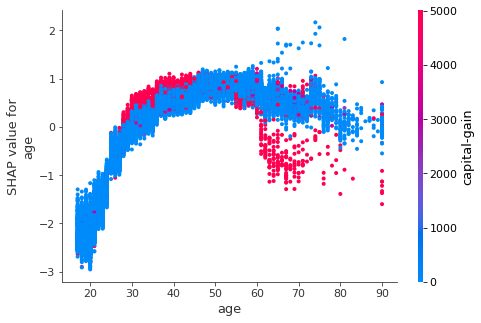

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


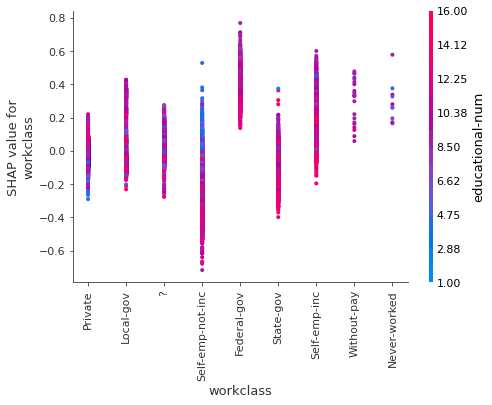

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


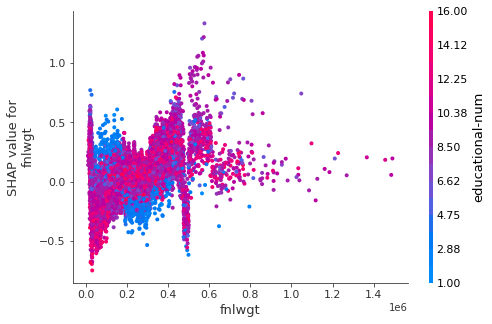

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


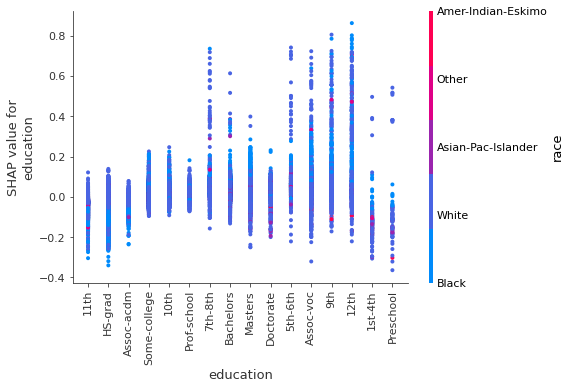

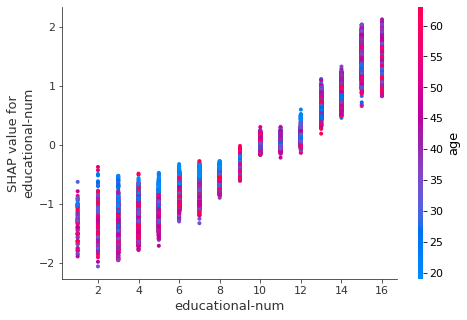

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


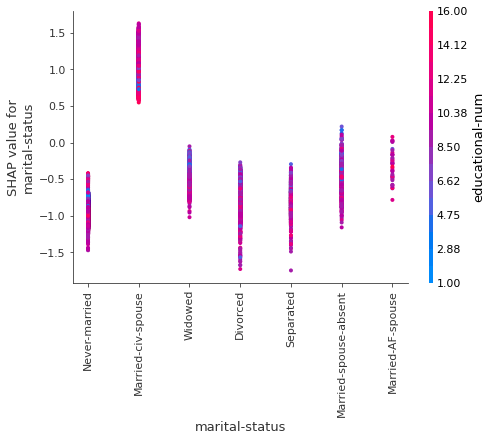

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


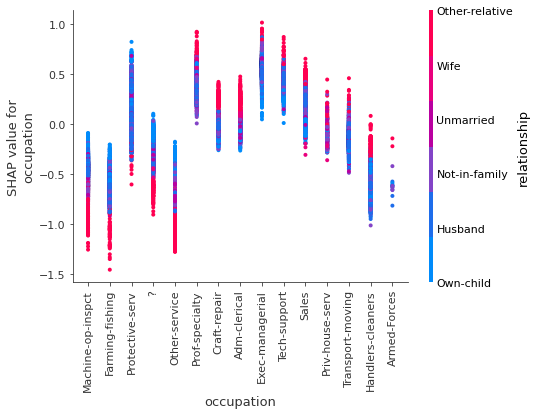

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


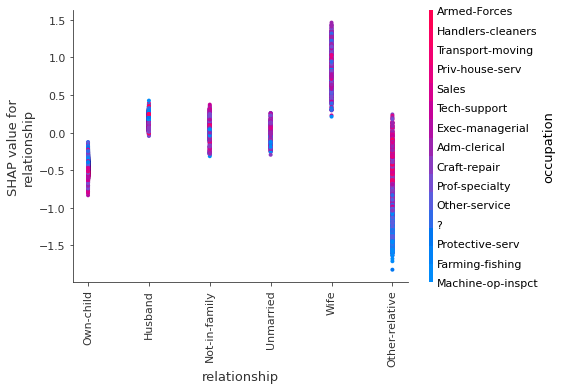

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


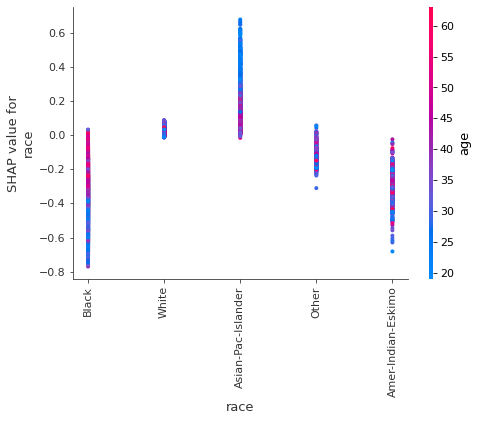

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


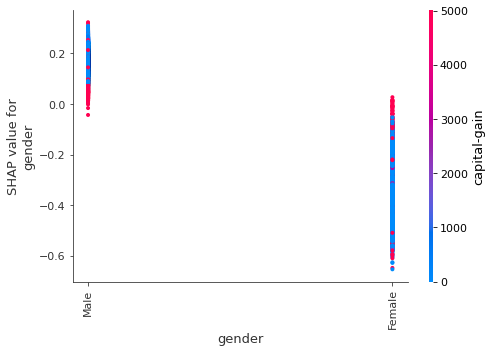

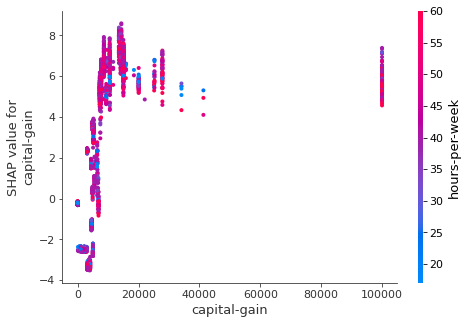

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


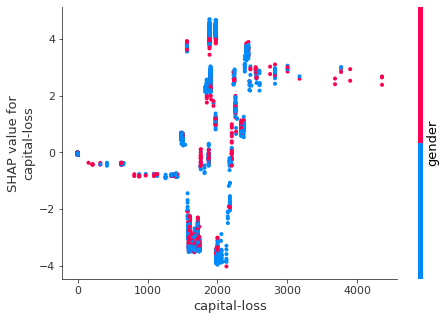

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


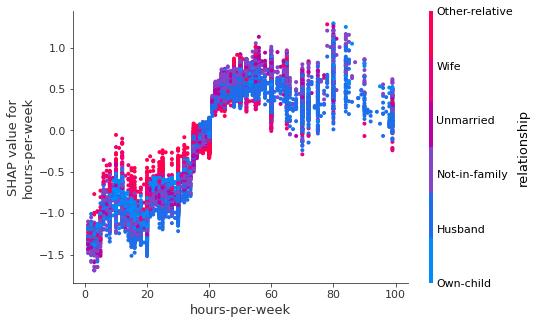

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


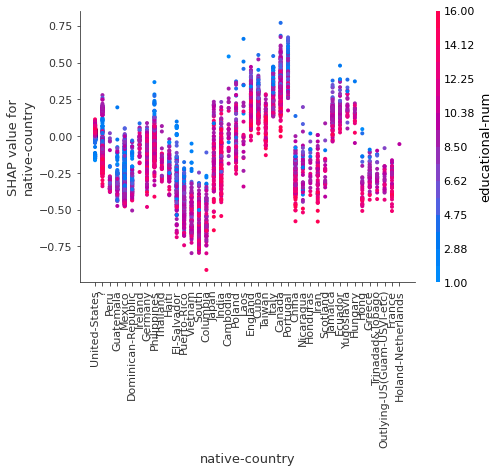

In [34]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values[1], X , display_features=X_display)
